### EDA для текстовых данных

В отличие от числовых данных, текстовые требуют анализа содержимого и структуры. Основные шаги EDA:
	
1.	Извлечение текста: Сбор данных из PDF для анализа.
2.	Базовая статистика: Подсчёт слов, символов, предложений.
3.	Частотный анализ: Топ популярных слов, биграмм, триграмм.
4.	Сравнение между группами: Анализ различий по регионам/категориям.
5.	Визуализация: Построение графиков, таких как облака слов, гистограммы.

Цель: получить представление о содержании, выявить ключевые слова, оценить объём информации для дальнейшей векторизации.

In [71]:
# библиотеки
import os
import re
import pandas as pd
import pdfplumber
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

from stop_words import get_stop_words
from IPython.display import display

In [72]:
# Путь к директории с отчетами
base_path = "../../data/Base_Books"

Результаты анализа сохранены в pdf_analysis_extended.csv


<Axes: title={'center': 'Общее количество таблиц и изображений в PDF'}, xlabel='Region'>

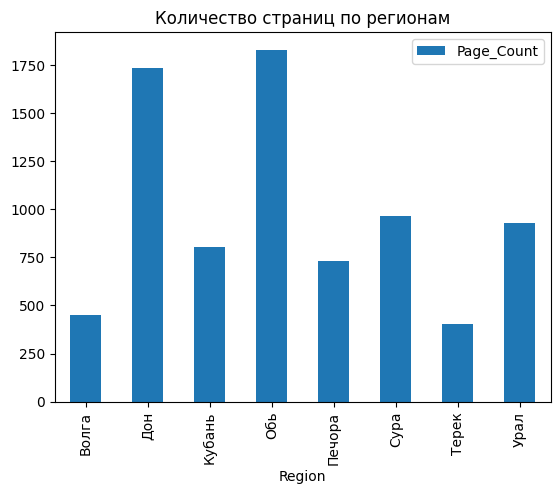

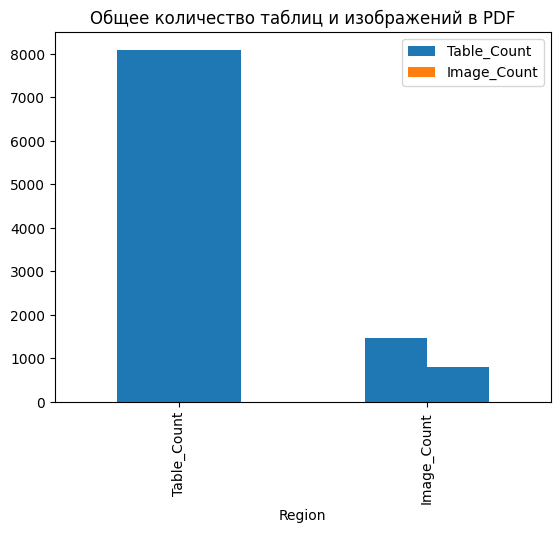

In [73]:
# Функция для извлечения текста и дополнительной информации из PDF
def analyze_pdf(file_path):
    text = ""
    page_count = 0
    table_count = 0
    image_count = 0

    try:
        with pdfplumber.open(file_path) as pdf:
            page_count = len(pdf.pages)
            for page in pdf.pages:
                # Извлечение текста
                text += page.extract_text() or ""
                # Подсчет таблиц
                table_count += len(page.extract_tables())
                # Подсчет изображений
                image_count += len(page.images)
    except Exception as e:
        print(f"Ошибка обработки файла {file_path}: {e}")

    return text, page_count, table_count, image_count

# Сбор данных
data = []
for region in os.listdir(base_path):
    region_path = os.path.join(base_path, region)
    if os.path.isdir(region_path):  # Проверяем, что это директория
        for book in os.listdir(region_path):
            book_path = os.path.join(region_path, book)
            if os.path.isdir(book_path):  # Проверяем, что это директория
                for pdf_file in os.listdir(book_path):
                    if pdf_file.endswith(".pdf"):  # Только PDF файлы
                        pdf_path = os.path.join(book_path, pdf_file)
                        text, page_count, table_count, image_count = analyze_pdf(pdf_path)
                        data.append({
                            "Region": region,
                            "Book": book,
                            "PDF_File": pdf_file,
                            "Text": text,
                            "Page_Count": page_count,
                            "Table_Count": table_count,
                            "Image_Count": image_count
                        })

# Создание DataFrame
df = pd.DataFrame(data)

# Сохранение результатов в файл
df.to_csv("pdf_analysis_extended.csv", index=False)
print("Результаты анализа сохранены в pdf_analysis_extended.csv")

# Визуализация: количество страниц по регионам
region_page_stats = df.groupby("Region")["Page_Count"].sum().reset_index()
region_page_stats.plot(kind="bar", x="Region", y="Page_Count", title="Количество страниц по регионам")

# Визуализация: количество таблиц и изображений по регионам
region_features = df.groupby("Region")[["Table_Count", "Image_Count"]].sum().reset_index()
region_features.plot(kind="bar", x="Region", title="Количество таблиц и изображений по регионам")

# Визуализация: общее количество таблиц и изображений
total_features = df[["Table_Count", "Image_Count"]].sum()
total_features.plot(kind="bar", title="Общее количество таблиц и изображений в PDF")

In [74]:
# Функция для извлечения текста из PDF
def extract_text_from_pdf(file_path):
    text = ""
    with pdfplumber.open(file_path) as pdf:
        for page in pdf.pages:
            text += page.extract_text()
    return text

# Сбор данных
data = []
for region in os.listdir(base_path):
    region_path = os.path.join(base_path, region)
    if os.path.isdir(region_path):  # Проверяем, что это директория
        for book in os.listdir(region_path):
            book_path = os.path.join(region_path, book)
            if os.path.isdir(book_path):  # Проверяем, что это директория
                for pdf_file in os.listdir(book_path):
                    if pdf_file.endswith(".pdf"):  # Только PDF файлы
                        pdf_path = os.path.join(book_path, pdf_file)
                        text = extract_text_from_pdf(pdf_path)
                        data.append({"Region": region, "Book": book, "PDF_File": pdf_file, "Text": text})

# Создание DataFrame
df = pd.DataFrame(data)

# Базовая статистика текста
df["Word_Count"] = df["Text"].apply(lambda x: len(x.split()))
df["Char_Count"] = df["Text"].apply(len)

# Частотный анализ
all_text = " ".join(df["Text"])
words = all_text.split()
word_counts = Counter(words).most_common(20)

#### Топ 20 ключевых слов по всем отчетам

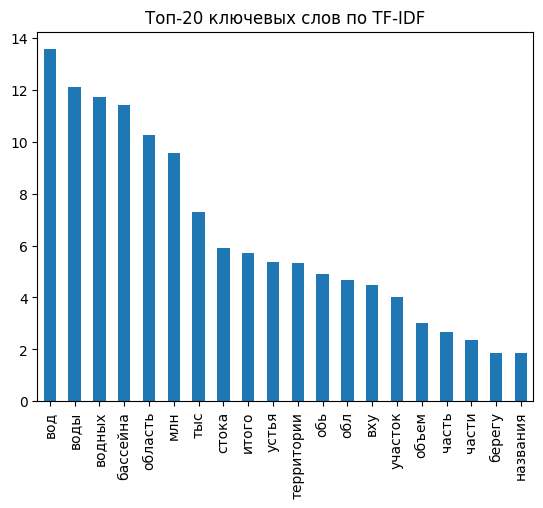

In [75]:
# Получение стоп-слов для русского языка
russian_stop_words = get_stop_words("russian")

# Функция для предварительной обработки текста
def preprocess_text(text):
    # Удаление чисел и токенов короче 2 символов
    tokens = re.findall(r'\b[^\d\W]{3,}\b', text, re.UNICODE)
    # Фильтрация стоп-слов
    tokens = [token for token in tokens if token.lower() not in russian_stop_words]
    return " ".join(tokens)

# Применение предобработки текста
df["Processed_Text"] = df["Text"].apply(preprocess_text)

# TF-IDF анализ
tfidf_vectorizer = TfidfVectorizer(max_features=20)  # Убираем стоп-слова, т.к. они уже обработаны
tfidf_matrix = tfidf_vectorizer.fit_transform(df["Processed_Text"])

# Создание DataFrame с результатами
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=tfidf_vectorizer.get_feature_names_out(),
    index=df["PDF_File"]
)

# Визуализация: Топ-20 частых слов
tfidf_df.T.sum(axis=1).sort_values(ascending=False).plot(kind='bar', title="Топ-20 ключевых слов по TF-IDF")
plt.show()

#### Облако слов

/Users/anastasia/docs/Projects/skiovo_project/.venv/lib/python3.10/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


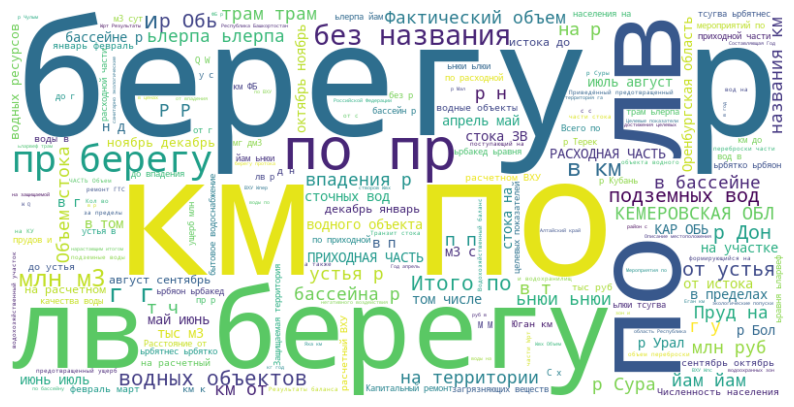

In [76]:
# Визуализация: Облако слов
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

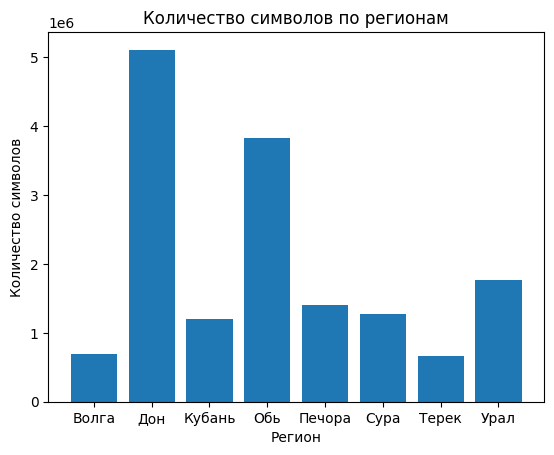

In [77]:
# График количества символов по регионам
region_stats = df.groupby('Region')['Char_Count'].sum().reset_index()

plt.bar(region_stats['Region'], region_stats['Char_Count'])
plt.title('Количество символов по регионам')
plt.xlabel('Регион')
plt.ylabel('Количество символов')
plt.show()

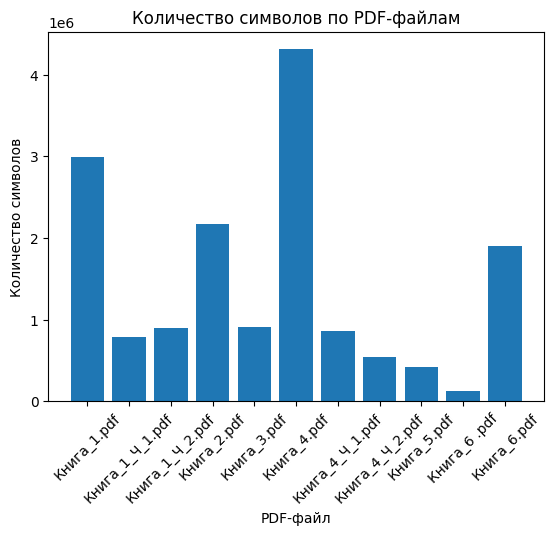

In [78]:
# График количества символов по файлам PDF
pdf_stats = df.groupby('PDF_File')['Char_Count'].sum().reset_index()

plt.bar(pdf_stats['PDF_File'], pdf_stats['Char_Count'])
plt.title('Количество символов по PDF-файлам')
plt.xlabel('PDF-файл')
plt.ylabel('Количество символов')
plt.xticks(rotation=45)
plt.show()

In [79]:
# Для TF-IDF
display(tfidf_df.head(10))

,бассейна,берегу,вод,водных,воды,вху,итого,млн,названия,обл,область,объем,обь,стока,территории,тыс,устья,участок,части,часть
PDF_File,,,,,,,,,,,,,,,,,,,,
Книга_3.pdf,0.443379,0.000000,0.469982,0.656201,0.221689,0.000000,0.000000,0.000000,0.000000,0.014185,0.000000,0.000000,0.000000,0.009592,0.115102,0.159640,0.239797,0.050884,0.059865,0.009222
Книга_4.pdf,0.056720,0.000000,0.157554,0.030611,0.800376,0.010338,0.281983,0.276112,0.000000,0.000000,0.000000,0.158089,0.000000,0.071091,0.123678,0.004052,0.039928,0.243842,0.124599,0.229400
Книга_5.pdf,0.124683,0.000000,0.696761,0.579411,0.124683,0.084217,0.000000,0.339827,0.000000,0.000000,0.000000,0.008586,0.000000,0.000000,0.007933,0.000000,0.095200,0.126257,0.000000,0.000000
Книга_2.pdf,0.456172,0.000000,0.642495,0.485084,0.298760,0.027666,0.008315,0.088599,0.000000,0.005139,0.016297,0.018803,0.000000,0.052123,0.180693,0.075906,0.031274,0.011060,0.054218,0.006682
Книга_1.pdf,0.378082,0.012270,0.360543,0.134473,0.405367,0.030770,0.002522,0.657892,0.000000,0.015587,0.012358,0.006844,0.000000,0.193941,0.126484,0.070170,0.174969,0.100647,0.085519,0.060805
Книга_6.pdf,0.066725,0.004001,0.108667,0.215428,0.030503,0.000000,0.088826,0.006309,0.000000,0.006099,0.003627,0.033476,0.000000,0.006186,0.013404,0.962058,0.035057,0.013127,0.009653,0.003965
Книга_3.pdf,0.053818,0.000000,0.038087,0.032291,0.043054,0.074869,0.000000,0.000913,0.003682,0.000000,0.013651,0.000969,0.992681,0.008060,0.018808,0.008384,0.027764,0.001900,0.011179,0.012055
Книга_4_Ч_2.pdf,0.002055,0.000000,0.005823,0.001028,0.004796,0.061456,0.000000,0.000000,0.011426,0.947370,0.000869,0.000000,0.310711,0.000000,0.001112,0.000000,0.011486,0.042849,0.000000,0.002850
Книга_4_Ч_1.pdf,0.008538,0.000000,0.179533,0.004615,0.062075,0.708473,0.079743,0.071535,0.000000,0.000000,0.000000,0.417360,0.246939,0.386397,0.000000,0.000000,0.002496,0.061176,0.210832,0.133197


In [80]:
# Для общей таблицы
display(df.head(10))

,Region,Book,PDF_File,Text,Word_Count,Char_Count,Processed_Text
0,Печора,Книга 3,Книга_3.pdf,УТВЕРЖДЕНА\nприказом Двинско-Печорского БВУ\nФ...,13010,78841,УТВЕРЖДЕНА приказом Двинско Печорского БВУ Фед...
1,Печора,Книга 4,Книга_4.pdf,УТВЕРЖДЕНА\nприказом Двинско-Печорского БВУ\nФ...,95326,582209,УТВЕРЖДЕНА приказом Двинско Печорского БВУ Фед...
2,Печора,Книга 5,Книга_5.pdf,УТВЕРЖДЕНА\nприказом Двинско-Печорского БВУ\nФ...,5952,41990,УТВЕРЖДЕНА приказом Двинско Печорского БВУ Фед...
3,Печора,Книга 2,Книга_2.pdf,УТВЕРЖДЕНА\nприказом Двинско-Печорского БВУ\nФ...,18011,135260,УТВЕРЖДЕНА приказом Двинско Печорского БВУ Фед...
4,Печора,Книга 1,Книга_1.pdf,УТВЕРЖДЕНА\nприказом Двинско-Печорского БВУ\nФ...,50808,316222,УТВЕРЖДЕНА приказом Двинско Печорского БВУ Фед...
5,Печора,Книга 6,Книга_6.pdf,УТВЕРЖДЕНА\nприказом Двинско-Печорского БВУ\nФ...,42304,242562,УТВЕРЖДЕНА приказом Двинско Печорского БВУ Фед...
6,Обь,Книга 3,Книга_3.pdf,УТВЕРЖДЕНА\nприказом Нижне-Обского БВУ\nот «25...,25869,132740,УТВЕРЖДЕНА приказом Нижне Обского БВУ августа ...
7,Обь,Книга 4,Книга_4_Ч_2.pdf,УТВЕРЖДЕНА\nприказом Нижне-Обского БВУ\nот «25...,100875,547083,УТВЕРЖДЕНА приказом Нижне Обского БВУ августа ...
8,Обь,Книга 4,Книга_4_Ч_1.pdf,УТВЕРЖДЕНА\nприказом Нижне-Обского БВУ\nот «25...,132908,860329,УТВЕРЖДЕНА приказом Нижне Обского БВУ августа ...
9,Обь,Книга 5,Книга_5.pdf,УТВЕРЖДЕНА\nприказом Нижне-Обского БВУ\nот «25...,7087,42305,УТВЕРЖДЕНА приказом Нижне Обского БВУ августа ...
